# Variable Selection

In prediction we use a series of independent variables to predict an outcome. We assume that these predictors have a correlation with the dependent variable and hence can be used to establish its value. While this is usually the case, there are scenarios where not all variables have significant effects on the predicted variable. As so, it is useful to carry out some analysis to evaluate the ability of these explanatory variables to influence the prediction as to remove those which have less signifficant impact and hence make the model more parsimonious.

One method used for this purpose is LASSO, which stands for "least absolute shrinkage and selection operator". It is a linear regression with a penality that reduces the beta coefficients to zero at a certain rate. By looking at the path that these coefficients take, one can etablish the variables that are most effective and use these for creating models.

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, Lasso


# Import Data

In [2]:
X_train = pd.read_csv('0_X_train.csv', index_col='Id')
X_valid = pd.read_csv('1_X_valid.csv', index_col='Id')
X_test  = pd.read_csv('2_X_test.csv', index_col='Id')

y_train = pd.read_csv('0_y_train.csv', index_col='Id')
y_valid = pd.read_csv('1_y_valid.csv', index_col='Id')
y_test  = pd.read_csv('2_y_test.csv', index_col='Id')

num_vars = ['age', 'time_spent', 'banner_views', 'banner_views_old', 'days_elapsed_old', 'X4']

First we remove the columns that are categorical as these do not work for linear regression

In [3]:
X_train = X_train.drop(columns=['marital_married', 'outcome_old_failure', 'job_manager'])
X_valid = X_valid.drop(columns=['marital_married', 'outcome_old_failure', 'job_manager'])
X_test  = X_test.drop(columns=['marital_married', 'outcome_old_failure', 'job_manager'])

Next we create a column transformer to standardize the numerical values.

In [4]:
std_num = ColumnTransformer(transformers=[('std_num', StandardScaler(), num_vars)],
                            remainder='passthrough')

Then, we create a pipeline to use for future transformations. It is valid to note that regular `scikitlearn` function is used only for linear regression. As classification problems require a binary output, logistic regression is used instead. The equivalent though is to use the $\ell_{1}$-norm penalization of the $\beta$ coefficients.

Additionally, the penalty $\lambda$ is given as the parameter `C` (Cost) in the `LogisticRegression()` function.

In [5]:
lasso_pipe = Pipeline([
    ('std_num', std_num),
    ('lasso_log', LogisticRegression(penalty='l1', solver='liblinear', C=1, fit_intercept=True, class_weight='balanced'))
])

Once the pipeli

In [7]:
y_train = np.array(y_train)
y_train = y_train.ravel()

To find the best combination of parameters for the Lasso regresion, we create a `GridSearch` that runs the function changing the parameters each time. Therefore, we get in a single object the main results for each combination of parameter inputs. 

In [8]:
lasso_grid = np.linspace(start=0.0001, stop=0.2, num=100)

lassoCV = GridSearchCV(estimator=lasso_pipe,
                       param_grid={'lasso_log__C': lasso_grid},
                       scoring="accuracy",
                       cv=KFold(n_splits=10, shuffle=True, random_state=42),
                       n_jobs=-2)

lassoCV.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_num',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('std_num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'time_spent',
                                                                          'banner_views',
                                                                          'banner_views_old',
                                                                          'days_elapsed_old',
                                                                          'X4'])])),
                                       ('lasso_log',
                                        LogisticRegression(C=1,
                                                           class_weight='balanced',
                                                           penalty='l1',
                                                           solver='l...
       1.53558586e-01, 1.55577778e-01, 1.57596970e-01, 1.59616162e-01,
       1.61635354e-01, 1.63654545e-01, 1.65673737e-01, 1.67692929e-01,
       1.69712121e-01, 1.71731313e-01, 1.73750505e-01, 1.75769697e-01,
       1.77788889e-01, 1.79808081e-01, 1.81827273e-01, 1.83846465e-01,
       1.85865657e-01, 1.87884848e-01, 1.89904040e-01, 1.91923232e-01,
       1.93942424e-01, 1.95961616e-01, 1.97980808e-01, 2.00000000e-01])},
             scoring='accuracy')

In [10]:
pd.DataFrame(lassoCV.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso_log__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.023919,0.003177,0.006251,0.000628,0.0001,{'lasso_log__C': 0.0001},0.566188,0.607656,0.593301,0.590112,0.537480,0.590112,0.602236,0.581470,0.584665,0.579872,0.583309,0.018852,100
1,0.029502,0.004290,0.005771,0.000875,0.002119,{'lasso_log__C': 0.002119191919191919},0.728868,0.728868,0.738437,0.743222,0.727273,0.755981,0.738019,0.728435,0.742812,0.744409,0.737632,0.008871,99
2,0.033598,0.007392,0.006358,0.002912,0.004138,{'lasso_log__C': 0.004138383838383839},0.783094,0.759171,0.778309,0.781499,0.771930,0.799043,0.784345,0.766773,0.774760,0.761981,0.776091,0.011267,98
3,0.031060,0.003932,0.006248,0.001721,0.006158,{'lasso_log__C': 0.006157575757575758},0.802233,0.781499,0.807018,0.794258,0.795853,0.810207,0.779553,0.801917,0.793930,0.784345,0.795081,0.010063,97
4,0.036280,0.007728,0.005830,0.001133,0.008177,{'lasso_log__C': 0.008176767676767676},0.802233,0.800638,0.816587,0.807018,0.797448,0.811802,0.785942,0.803514,0.797125,0.793930,0.801624,0.008392,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.082816,0.026932,0.013782,0.012856,0.191923,{'lasso_log__C': 0.19192323232323233},0.822967,0.810207,0.835726,0.829346,0.810207,0.821372,0.798722,0.830671,0.819489,0.814696,0.819340,0.010620,6
96,0.073905,0.023392,0.007754,0.004885,0.193942,{'lasso_log__C': 0.19394242424242425},0.822967,0.810207,0.835726,0.827751,0.810207,0.821372,0.798722,0.830671,0.819489,0.814696,0.819181,0.010479,20
97,0.065923,0.014246,0.008259,0.005780,0.195962,{'lasso_log__C': 0.19596161616161614},0.822967,0.810207,0.835726,0.827751,0.810207,0.819777,0.798722,0.830671,0.819489,0.814696,0.819021,0.010457,25
98,0.064673,0.017700,0.006015,0.000814,0.197981,{'lasso_log__C': 0.19798080808080806},0.822967,0.810207,0.835726,0.827751,0.810207,0.819777,0.798722,0.830671,0.819489,0.814696,0.819021,0.010457,25


In [11]:
# Choose best model that minimizes cv_err
mean_scores = lassoCV.cv_results_["mean_test_score"]
std_scores = lassoCV.cv_results_["std_test_score"] / np.sqrt(lassoCV.n_splits_)
C_values = lassoCV.cv_results_["param_lasso_log__C"].data

best_index = np.argmax(mean_scores)
max_C_lasso = C_values[best_index]
threshold_lasso = mean_scores[best_index] - std_scores[best_index]
one_std_rule_C_lasso = np.max(C_values[mean_scores <= threshold_lasso])

print("Minimum C:", max_C_lasso)
print("1-SD C:", one_std_rule_C_lasso)
print("Best score for lasso:", np.max(mean_scores))

Minimum C: 0.16163535353535352
1-SD C: 0.06067575757575758
Best score for lasso: 0.8196590081069651


We can use the above variables to plot the behavior of the error through the various calculations.

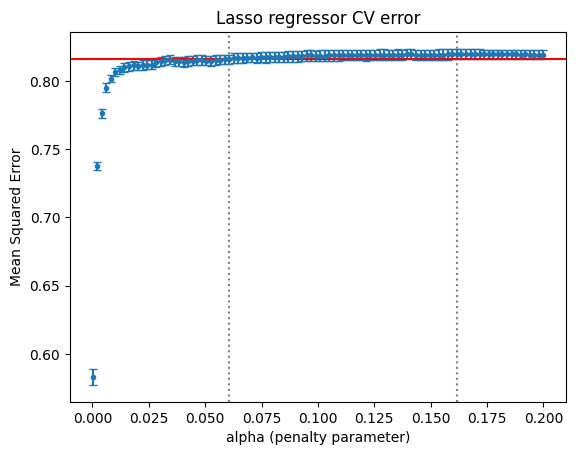

In [12]:
# plt.figure(figsize=(7,6))
plt.errorbar(x=C_values, y=mean_scores, yerr=std_scores, fmt='.', capsize=3)

plt.axvline(x=max_C_lasso, ls='dotted', color="grey")  # vertical line at the k yielding minimum CV MSE
plt.axvline(x=one_std_rule_C_lasso, ls='dotted', color="grey")   # vertical line at best k value according to 1 std err rule
plt.axhline(y=threshold_lasso, color="red")  # horizontal line line at best k value according to 1 std err rule

plt.title("Lasso regressor CV error")
plt.xlabel('alpha (penalty parameter)')
plt.ylabel('Mean Squared Error')
plt.show()

Now we can use the result of the best Lasso regression to predict the values of the validation data set and check its accuracy.

In [13]:
y_valid_pred = lassoCV.predict(X_valid)
accuracy_score(y_valid_pred, y_valid)

0.8071481757259866

In [14]:
lasso_grid = np.linspace(start=0.0001, stop=0.2, num=100)

coefs_ = []
for C in lasso_grid:
    lasso_pipe.set_params(lasso_log__C=C)
    lasso_pipe.fit(X=X_train, y=y_train)
    coefs_.append(lasso_pipe.named_steps['lasso_log'].coef_.ravel().copy())

coefs_ = np.array(coefs_)

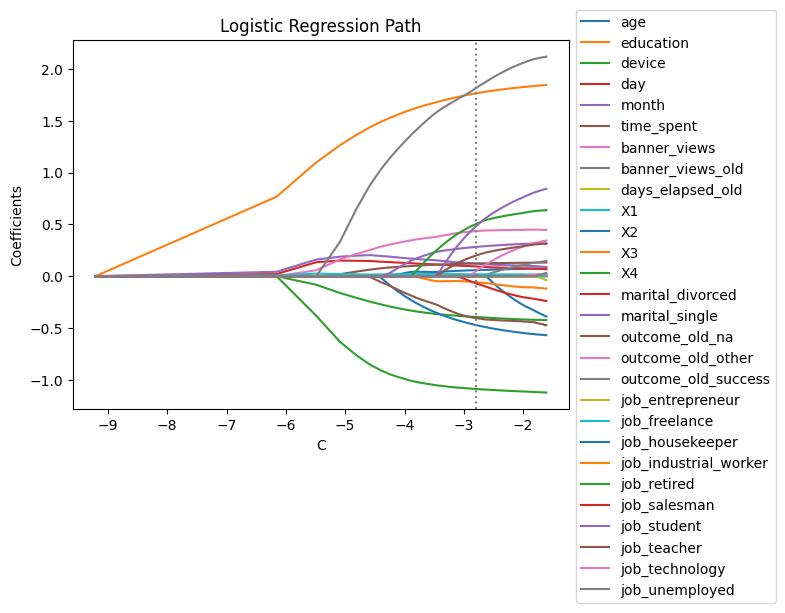

In [15]:
plt.plot(np.log(lasso_grid), coefs_, label=X_train.columns)
ymin, ymax = plt.ylim()
plt.axvline(x=np.log(one_std_rule_C_lasso), ls='dotted', color="grey")
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.1))
plt.xlabel("C")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Path")
plt.axis("tight")
plt.show()

In [18]:
lasso_pipe = Pipeline([
    ('std_num', std_num),
    ('lasso_log', LogisticRegression(penalty='l1', solver='liblinear', C=one_std_rule_C_lasso, fit_intercept=True, class_weight='balanced'))
])

In [19]:
print(accuracy_score(y_pred=lasso_pipe.predict(X_train), y_true=y_train))
print(accuracy_score(y_pred=lasso_pipe.predict(X_valid), y_true=y_valid))
print(accuracy_score(y_pred=lasso_pipe.predict(X_test), y_true=y_test))

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [20]:
lasso_coefs = lasso_pipe.named_steps['lasso_log'].coef_
lasso_coefs = lasso_coefs.ravel()

lasso_coefs = pd.DataFrame({'col_names': X_train.columns, 'coef': lasso_coefs})
plt.bar(lasso_coefs['col_names'], np.abs(lasso_coefs['coef']))
plt.xticks(rotation = 90)
plt.show()

AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [ ]:
cols_lasso = ['banner_views_old', 'days_elapsed_old', 'X3', 'marital_divorced', 'job_entrepreneur', 'job_freelance',
             'job_housekeeper', 'job_technology', 'job_unemployed']

num_vars = ['age', 'time_spent', 'banner_views', 'X4']
std_num = ColumnTransformer(transformers=[('std_num', StandardScaler(), num_vars)],
                            remainder='passthrough')

X_train_reduced = X_train.drop(columns=cols_lasso)

lasso_pipe = Pipeline([
    ('std_num', std_num),
    ('lasso_log', LogisticRegression(solver='liblinear', fit_intercept=True, class_weight='balanced'))
])

lasso_pipe.fit(X_train_reduced, y_train)